## Image Multiclassification

- Implement One vs One scheme for image classification
- To Use SVM for image classification

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

### Data Preparation and Reading

In [21]:
p=Path("../images")
dirs=p.glob("*")
labels=[]
img_data=[]

dirt={
    "cat":0,
    "dog":1,
    "horse":2,
    "human":3
}

for folder_name in dirs:
    #print(folder_name)
    label=str(folder_name).split("\\")[-1][:-1]
    
    for img_path in folder_name.glob("*.jpg"):
        img_path=str(img_path).replace("\\","//")
        img=cv2.imread(img_path)
        rgb_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        rgb_img=cv2.resize(rgb_img,(32,32))
        img_data.append(rgb_img)
        labels.append(dirt[label])
    
print(len(img_data),len(labels))

808 808


In [22]:
#Converting to numpy array

img_data=np.array(img_data)
labels=np.array(labels)

img_data.shape,labels.shape

((808, 32, 32, 3), (808,))

## Randomly shuffle our data



In [23]:
import random

data=list(zip(img_data,labels))
random.shuffle(data)

#Unzip
img_data[:],labels[:]=zip(*data)

## Visualise Data

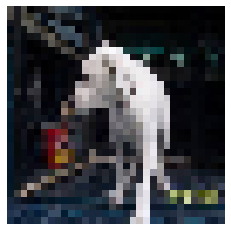

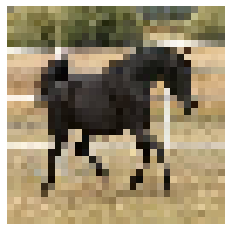

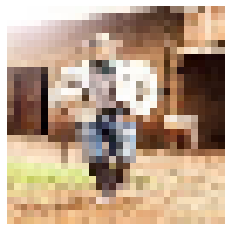

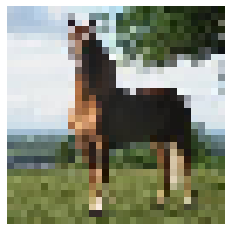

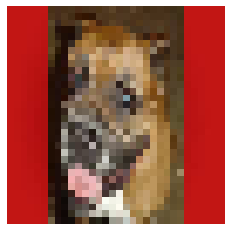

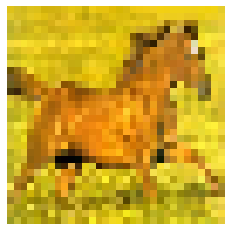

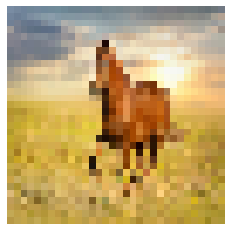

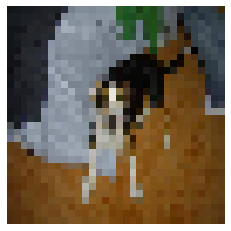

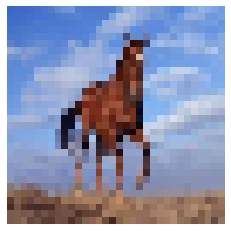

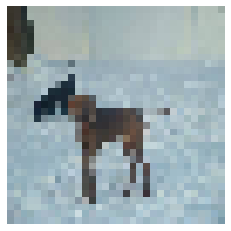

In [24]:
def draw_img(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return

for i in range(10):
    draw_img(img_data[i])

### SVM Classifier

In [25]:
class SVM:
    
    def __init__(self,C=1.0):
        self.C=C
        self.W=0
        self.b=0
        
        
    def hingeLoss(self,W,b,X,Y):
        m=X.shape[0]
        loss=0.0
        loss+=0.5*np.dot(W,W.T)
        
        for i in range(m):
            ti=Y[i]*(np.dot(W,X[i].T))+b
            loss+=self.C*(max(0,1-ti))
        
        return loss[0][0]
        
    
    def fit(self,X,Y,batch_size=100,learning_rate=0.001,max_itr=300):
        no_of_features=X.shape[1]
        no_of_samples=X.shape[0]
        
        c=self.C
        
        #Initiatize the model parameters
        W=np.zeros((1,no_of_features))
        bias=0
        
        #print(self.hingeLoss(W,bias,X,Y))
        
        #Training Here
        #Weight and Bias update rule
        
        losses=[]
        
        for i in range(max_itr):
            l=self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids=np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume Zero Gradient
                gradw=0
                gradb=0
                
                #Iterate over all examples in the batch size
                for j in range(batch_start,batch_start+batch_size):
                    if j <no_of_samples:
                        i=ids[j]
                        ti=Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>=1:
                            gradw+=0
                            gradb+=0
                            
                        else:
                            gradw+=c*Y[i]*X[i]
                            gradb+=c*Y[i]
                
                #Gradient for the batch is ready, Update Weight and bias
                
                W=W-learning_rate*W+learning_rate*gradw
                bias=bias+learning_rate*gradb
            
        
        self.W=W
        self.b=bias
        return W,bias,losses

### We need to convert our data to One vs One Classification

In [26]:
M=img_data.shape[0]

img_data=img_data.reshape(M,-1)

img_data.shape,labels.shape

((808, 3072), (808,))

In [27]:
Classes=len(np.unique(labels))
Classes

4

In [28]:
def classWiseData(X,Y):
    data={}
    
    for i in range(Classes):
        data[i]=list()
        
    for i in range(X.shape[0]):
        data[Y[i]].append(X[i])
        
    for k in data.keys():
        data[k]=np.array(data[k])
    return data

In [29]:
data=classWiseData(img_data,labels)
data

{0: array([[ 58,  38,  27, ...,  44,  33,  29],
        [ 58,  38,  27, ...,  44,  33,  29],
        [208, 200, 184, ..., 133,  63,  14],
        ...,
        [166, 142, 134, ...,  93,  76,  68],
        [ 15,  19,   3, ..., 129, 131,  69],
        [135, 128, 102, ..., 195, 174, 117]], dtype=uint8),
 1: array([[ 78,  75,  70, ...,  33,  47,  68],
        [194,  22,  20, ..., 194,  22,  20],
        [ 16,  22,  26, ...,  81,  48,  15],
        ...,
        [ 10,  15,  11, ..., 143, 136, 118],
        [180, 195, 198, ...,  89,  59,  35],
        [ 69,  79,  42, ..., 253, 253, 253]], dtype=uint8),
 2: array([[135, 128, 102, ..., 195, 174, 117],
        [186, 203, 221, ...,  97, 106,  49],
        [222, 194,  26, ..., 227, 200,  60],
        ...,
        [176, 160, 119, ..., 145, 119,  59],
        [ 24,  19,  16, ...,  50,  41,  34],
        [157, 154, 135, ..., 145, 147, 146]], dtype=uint8),
 3: array([[255, 255, 255, ..., 225, 185, 144],
        [109, 117,  58, ..., 128, 120,  91],
    

In [30]:
data[0].shape

(202, 3072)

## Training NC2 SVM Part

In [49]:
def getDataPairsForSVM(d1,d2):
    
    '''Combined datas of two classes into one'''
    
    l1,l2=d1.shape[0],d2.shape[0]
    samples=l1+l2
    features=d1.shape[1]
    
    data_pair=np.zeros((samples,features))
    data_labels=np.zeros((samples,))
    
    data_pair[:l1,:]=d1
    data_pair[l1:,:]=d2
    
    data_labels[:l1]=-1
    data_labels[l1]=+1
    
    return data_pair,data_labels

def classWiseData(X,Y):
    data={}
    
    for i in range(Classes):
        data[i]=[]
        
    for i in range(X.shape[0]):
        data[Y[i]].append(X[i])
        
    for k in data.keys():
        data[k]=np.array(data[k])
    return data

def trainSVMs(X,Y):
    svm=SVM()
    svm_classifiers={}
    
    #data=classWiseData(X,Y)
    
    for i in range(Classes):
        svm_classifiers[i]={}
        
        for j in range(i+1,Classes):
            Xpair,Ypair=getDataPairsForSVM(data[i],data[j])
            wts,bias,loss=svm.fit(Xpair,Ypair)
            svm_classifiers[i][j]=(wts,bias)
    
    return svm_classifiers

In [50]:
svm_classifiers=trainSVMs(img_data,label)

In [51]:
#Parameters for cats and dogs

cat_dogs=svm_classifiers[0][1]
print(cat_dogs[0].shape) #weights
print(cat_dogs[1]) #bias

(1, 3072)
-0.012999999999999963


## Predictions

In [55]:
def binaryPredict(x,w,b):
    z=np.dot(x,w.T)+b
    if z>=0:
        return 1
    else:
        return -1


def predict(x):
    count=np.zeros((Classes,))
    
    for i in range(Classes):
        for j in range(i+1,Classes):
            w,b=svm_classifiers[i][j]
            #Take a majority prediction
            z=binaryPredict(x,w,b)
            if z==1:
                count[j]+=1
            else:
                count[i]+=1
                
    print(count)
    return np.argmax(count)
            

In [56]:
print(predict(img_data[0]))
print(labels[0])

-1
-1
-1
-1
-1
-1
[3. 2. 1. 0.]
0
1
